# Line Optimiser for ControllerForge
The line optimiser is used to ensure that wires have roughly equal length and do not cross in the program.
This can be used for PCB generation, but is primarily used to ensure that conductive filament wires are of similar resistance.

## Setup
The below code is used to setup the libraries and key functions required for the genetic algorithms

### Library Imports
The Line Optimiser uses NetworkX for the graphs, shapely to check if lines overlap, and numpy for mathematical purposes.
DEAP, PyGAD, and geneticalgorithm are used for comparison of potential implementations. matplotlib visualises the final graph.

In [23]:
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pygad
from deap import base, creator, tools, algorithms
from geneticalgorithm import geneticalgorithm as ga
from shapely.geometry import LineString

### Function Definitions
**lines_intersect** takes two line variables (which contain the X and Y locations for the start and end of each line) and then uses shapely to create two LineStrings and then checks if they intersect.

**graph_single_source** creates a graph from a singular source to multiple nodes, this is used if a single point needs to connect to multiple nodes. The NetworkX graph is returned.

**graph_multiple_source** creates a graph from multiple sources to multiple nodes with a 1-to-1 relationship. The amount of nodes must be equal to the amount of sources, with nodes and sources being connected if they share the same index. The NetworkX graph is returned.

**plot_graph** plots a NetworkX graph using the optimal order. It works for graphs created through both ***graph_single_source*** and ***graph_multiple_source***.

In [24]:
def lines_intersect(line1, line2):
    l1 = LineString([line1[0], line1[1]])
    l2 = LineString([line2[0], line2[1]])
    return l1.intersects(l2)

In [25]:
def graph_single_source(source = (0,0), nodes= [(1, 2), (3, 1), (4, 5), (5, 3)]):
    G = nx.Graph()
    G.add_node('source', pos=source)
    for i, node in enumerate(nodes):
        G.add_node(f'node{i}', pos=node)
        G.add_edge('source', f'node{i}')
    return G
graph_single_source()

In [26]:
def graph_multiple_source(sources = [(0, 0), (1, 0), (0, 1), (1, 1)], nodes= [(1, 2), (3, 1), (4, 5), (5, 3)]):
    G = nx.Graph()
    assert len(sources) == len(nodes)
    for i, source in enumerate(sources):
        G.add_node(f'source{i}', pos=source)
    for i, node in enumerate(nodes):
        G.add_node(f'node{i}', pos=node)
        G.add_edge(f'source{i}', f'node{i}')
    return G
graph_multiple_source()

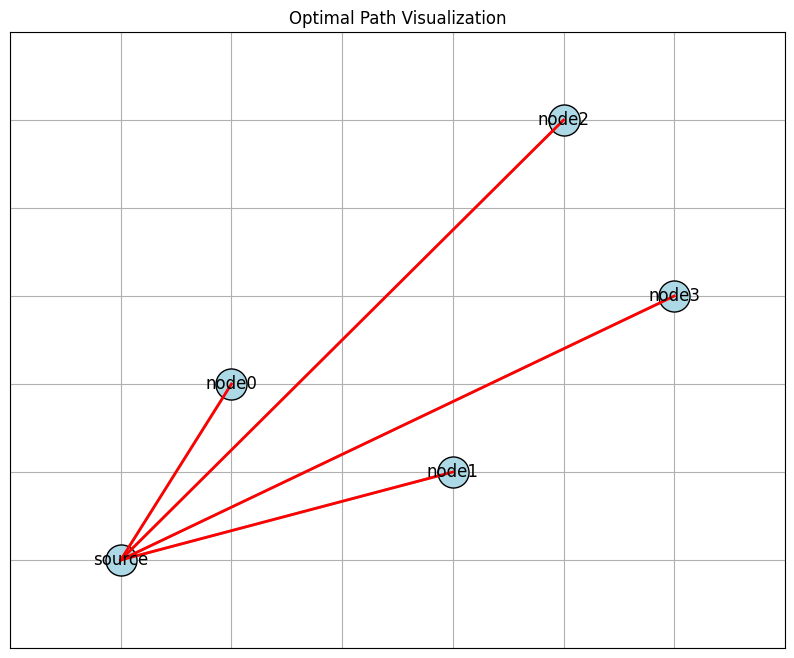

In [29]:
def plot_graph(G, optimal_order):
    # Get positions for nodes
    pos = nx.get_node_attributes(G, 'pos')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color='lightblue', edgecolors='black')
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=G.edges(), width=2, alpha=0.6, edge_color='gray')
    
    num_sources = len([n for n in G.nodes if n.startswith('source')])
    
    if num_sources == 1:
        # Single-source scenario
        source_node = 'source'
        for node_idx in optimal_order:
            target_node = f'node{node_idx}'
            source_pos = pos[source_node]
            target_pos = pos[target_node]
            ax.plot([source_pos[0], target_pos[0]], [source_pos[1], target_pos[1]], 'r-', lw=2)
    
    elif num_sources > 1:
        # Multiple-source scenario
        for i, node_idx in enumerate(optimal_order):
            source_node = f'source{i}'
            target_node = f'node{node_idx}'
            source_pos = pos[source_node]
            target_pos = pos[target_node]
            ax.plot([source_pos[0], target_pos[0]], [source_pos[1], target_pos[1]], 'r-', lw=2)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=ax, labels={n: f'{n}' for n in G.nodes()}, font_size=12)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 6)
    ax.set_title('Optimal Path Visualization')
    plt.grid(True)
    plt.show()
plot_graph(graph_single_source(), [3,1,0,2])

## geneticalgorithm Implementation

In [11]:
# Define fitness function for GA
def fitness_function(solution, G):
    total_length = 0
    edges = []
    for node_idx in solution:
        node_idx = int(node_idx)
        p1 = G.nodes['source']['pos']
        p2 = G.nodes[f'node{node_idx}']['pos']
        total_length += np.linalg.norm(np.array(p1) - np.array(p2))
        edges.append((p1, p2))
    
    # Penalty for crossing edges
    for i in range(len(edges)):
        for j in range(i + 1, len(edges)):
            if lines_intersect(edges[i], edges[j]):
                total_length += 1000  # Large penalty for crossings
    
    return total_length

 The best solution found:                                                                           
 [0. 0. 0. 0.]

 Objective function:
 6008.944271909999


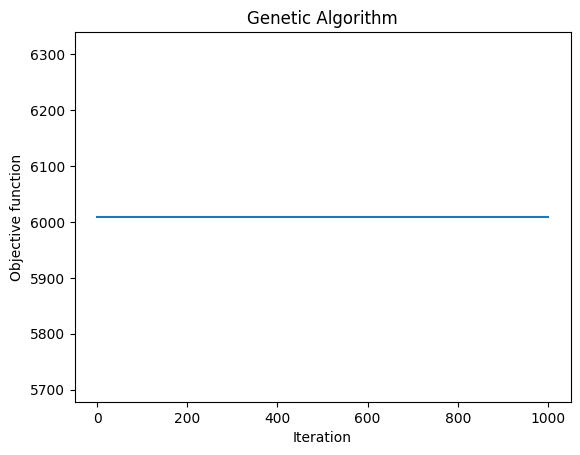

No solution found.


In [15]:
source = (0,0)
nodes = [(1, 2), (3, 1), (4, 5), (5, 3)]
G = graph_single_source(source, nodes)

# GA setup
algorithm_param = {
    'max_num_iteration': 1000,
    'population_size': 100,
    'mutation_probability': 0.1,
    'elit_ratio': 0.01,
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': None
}

var_bound = np.array([[0, len(nodes) - 1]] * len(nodes))

# Wrapper function to use G inside fitness_function
def fitness_wrapper(solution):
    return fitness_function(solution, G)

model = ga(
    function=fitness_wrapper,
    dimension=len(nodes),
    variable_type='int',
    variable_boundaries=var_bound,
    algorithm_parameters=algorithm_param
)

# Run GA to find optimal configuration
solution = model.run()
# Check if the solution is valid
if solution:
    optimal_order = solution['variable']
    print(f"Optimal order: {optimal_order}")
else:
    print("No solution found.")


## DEAP Implementation

In [13]:
# Define evaluation function
def evaluate(individual):
    total_length = 0
    edges = []
    for node_idx in individual:
        p1 = G.nodes['source']['pos']
        p2 = G.nodes[f'node{node_idx}']['pos']
        total_length += np.linalg.norm(np.array(p1) - np.array(p2))
        edges.append((p1, p2))
    
    # Penalty for crossing edges
    for i in range(len(edges)):
        for j in range(i + 1, len(edges)):
            if lines_intersect(edges[i], edges[j]):
                total_length += 1000  # Large penalty for crossings

    return total_length,

gen	nevals	avg    	std        	min    	max    
0  	300   	6017.63	9.09495e-13	6017.63	6017.63
1  	221   	6017.63	9.09495e-13	6017.63	6017.63
2  	224   	6017.63	9.09495e-13	6017.63	6017.63
3  	227   	6017.63	9.09495e-13	6017.63	6017.63
4  	226   	6017.63	9.09495e-13	6017.63	6017.63
5  	219   	6017.63	9.09495e-13	6017.63	6017.63
6  	234   	6017.63	9.09495e-13	6017.63	6017.63
7  	217   	6017.63	9.09495e-13	6017.63	6017.63
8  	212   	6017.63	9.09495e-13	6017.63	6017.63
9  	217   	6017.63	9.09495e-13	6017.63	6017.63
10 	218   	6017.63	9.09495e-13	6017.63	6017.63
11 	229   	6017.63	9.09495e-13	6017.63	6017.63
12 	216   	6017.63	9.09495e-13	6017.63	6017.63
13 	230   	6017.63	9.09495e-13	6017.63	6017.63
14 	249   	6017.63	9.09495e-13	6017.63	6017.63
15 	225   	6017.63	9.09495e-13	6017.63	6017.63
16 	231   	6017.63	9.09495e-13	6017.63	6017.63
17 	227   	6017.63	9.09495e-13	6017.63	6017.63
18 	221   	6017.63	9.09495e-13	6017.63	6017.63
19 	222   	6017.63	9.09495e-13	6017.63	6017.63
20 	245   	60

174	211   	6017.63	9.09495e-13	6017.63	6017.63
175	227   	6017.63	9.09495e-13	6017.63	6017.63
176	224   	6017.63	9.09495e-13	6017.63	6017.63
177	241   	6017.63	9.09495e-13	6017.63	6017.63
178	225   	6017.63	9.09495e-13	6017.63	6017.63
179	233   	6017.63	9.09495e-13	6017.63	6017.63
180	220   	6017.63	9.09495e-13	6017.63	6017.63
181	225   	6017.63	9.09495e-13	6017.63	6017.63
182	204   	6017.63	9.09495e-13	6017.63	6017.63
183	210   	6017.63	9.09495e-13	6017.63	6017.63
184	209   	6017.63	9.09495e-13	6017.63	6017.63
185	226   	6017.63	9.09495e-13	6017.63	6017.63
186	221   	6017.63	9.09495e-13	6017.63	6017.63
187	230   	6017.63	9.09495e-13	6017.63	6017.63
188	210   	6017.63	9.09495e-13	6017.63	6017.63
189	201   	6017.63	9.09495e-13	6017.63	6017.63
190	236   	6017.63	9.09495e-13	6017.63	6017.63
191	237   	6017.63	9.09495e-13	6017.63	6017.63
192	214   	6017.63	9.09495e-13	6017.63	6017.63
193	222   	6017.63	9.09495e-13	6017.63	6017.63
194	233   	6017.63	9.09495e-13	6017.63	6017.63
195	232   	60

350	235   	6017.63	9.09495e-13	6017.63	6017.63
351	223   	6017.63	9.09495e-13	6017.63	6017.63
352	244   	6017.63	9.09495e-13	6017.63	6017.63
353	202   	6017.63	9.09495e-13	6017.63	6017.63
354	231   	6017.63	9.09495e-13	6017.63	6017.63
355	218   	6017.63	9.09495e-13	6017.63	6017.63
356	228   	6017.63	9.09495e-13	6017.63	6017.63
357	243   	6017.63	9.09495e-13	6017.63	6017.63
358	221   	6017.63	9.09495e-13	6017.63	6017.63
359	236   	6017.63	9.09495e-13	6017.63	6017.63
360	240   	6017.63	9.09495e-13	6017.63	6017.63
361	223   	6017.63	9.09495e-13	6017.63	6017.63
362	235   	6017.63	9.09495e-13	6017.63	6017.63
363	224   	6017.63	9.09495e-13	6017.63	6017.63
364	237   	6017.63	9.09495e-13	6017.63	6017.63
365	213   	6017.63	9.09495e-13	6017.63	6017.63
366	246   	6017.63	9.09495e-13	6017.63	6017.63
367	227   	6017.63	9.09495e-13	6017.63	6017.63
368	229   	6017.63	9.09495e-13	6017.63	6017.63
369	214   	6017.63	9.09495e-13	6017.63	6017.63
370	233   	6017.63	9.09495e-13	6017.63	6017.63
371	234   	60

527	242   	6017.63	9.09495e-13	6017.63	6017.63
528	231   	6017.63	9.09495e-13	6017.63	6017.63
529	228   	6017.63	9.09495e-13	6017.63	6017.63
530	226   	6017.63	9.09495e-13	6017.63	6017.63
531	233   	6017.63	9.09495e-13	6017.63	6017.63
532	236   	6017.63	9.09495e-13	6017.63	6017.63
533	215   	6017.63	9.09495e-13	6017.63	6017.63
534	220   	6017.63	9.09495e-13	6017.63	6017.63
535	235   	6017.63	9.09495e-13	6017.63	6017.63
536	239   	6017.63	9.09495e-13	6017.63	6017.63
537	228   	6017.63	9.09495e-13	6017.63	6017.63
538	235   	6017.63	9.09495e-13	6017.63	6017.63
539	226   	6017.63	9.09495e-13	6017.63	6017.63
540	234   	6017.63	9.09495e-13	6017.63	6017.63
541	242   	6017.63	9.09495e-13	6017.63	6017.63
542	216   	6017.63	9.09495e-13	6017.63	6017.63
543	218   	6017.63	9.09495e-13	6017.63	6017.63
544	215   	6017.63	9.09495e-13	6017.63	6017.63
545	220   	6017.63	9.09495e-13	6017.63	6017.63
546	214   	6017.63	9.09495e-13	6017.63	6017.63
547	207   	6017.63	9.09495e-13	6017.63	6017.63
548	222   	60

704	227   	6017.63	9.09495e-13	6017.63	6017.63
705	227   	6017.63	9.09495e-13	6017.63	6017.63
706	238   	6017.63	9.09495e-13	6017.63	6017.63
707	227   	6017.63	9.09495e-13	6017.63	6017.63
708	219   	6017.63	9.09495e-13	6017.63	6017.63
709	216   	6017.63	9.09495e-13	6017.63	6017.63
710	237   	6017.63	9.09495e-13	6017.63	6017.63
711	238   	6017.63	9.09495e-13	6017.63	6017.63
712	225   	6017.63	9.09495e-13	6017.63	6017.63
713	212   	6017.63	9.09495e-13	6017.63	6017.63
714	233   	6017.63	9.09495e-13	6017.63	6017.63
715	246   	6017.63	9.09495e-13	6017.63	6017.63
716	229   	6017.63	9.09495e-13	6017.63	6017.63
717	235   	6017.63	9.09495e-13	6017.63	6017.63
718	229   	6017.63	9.09495e-13	6017.63	6017.63
719	229   	6017.63	9.09495e-13	6017.63	6017.63
720	210   	6017.63	9.09495e-13	6017.63	6017.63
721	223   	6017.63	9.09495e-13	6017.63	6017.63
722	253   	6017.63	9.09495e-13	6017.63	6017.63
723	216   	6017.63	9.09495e-13	6017.63	6017.63
724	231   	6017.63	9.09495e-13	6017.63	6017.63
725	230   	60

881	222   	6017.63	9.09495e-13	6017.63	6017.63
882	239   	6017.63	9.09495e-13	6017.63	6017.63
883	234   	6017.63	9.09495e-13	6017.63	6017.63
884	214   	6017.63	9.09495e-13	6017.63	6017.63
885	228   	6017.63	9.09495e-13	6017.63	6017.63
886	231   	6017.63	9.09495e-13	6017.63	6017.63
887	228   	6017.63	9.09495e-13	6017.63	6017.63
888	239   	6017.63	9.09495e-13	6017.63	6017.63
889	217   	6017.63	9.09495e-13	6017.63	6017.63
890	224   	6017.63	9.09495e-13	6017.63	6017.63
891	222   	6017.63	9.09495e-13	6017.63	6017.63
892	228   	6017.63	9.09495e-13	6017.63	6017.63
893	229   	6017.63	9.09495e-13	6017.63	6017.63
894	212   	6017.63	9.09495e-13	6017.63	6017.63
895	243   	6017.63	9.09495e-13	6017.63	6017.63
896	210   	6017.63	9.09495e-13	6017.63	6017.63
897	229   	6017.63	9.09495e-13	6017.63	6017.63
898	216   	6017.63	9.09495e-13	6017.63	6017.63
899	210   	6017.63	9.09495e-13	6017.63	6017.63
900	226   	6017.63	9.09495e-13	6017.63	6017.63
901	220   	6017.63	9.09495e-13	6017.63	6017.63
902	225   	60

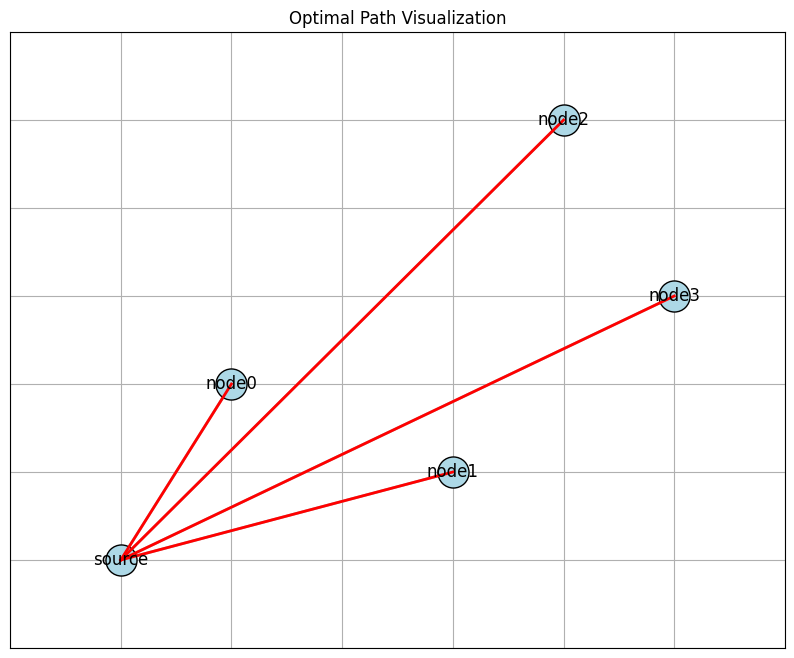

In [39]:
source = (0,0)
nodes= [(1, 2), (3, 1), (4, 5), (5, 3)]
G=graph_single_source(source, nodes)
# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(nodes)), len(nodes))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Genetic Algorithm
def main():
    population = toolbox.population(n=300)
    ngen = 1000
    cxpb = 0.7
    mutpb = 0.2
    
    # Stats to keep track of the progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, verbose=True)
    
    # Get the best individual
    best_ind = tools.selBest(population, 1)[0]
    return best_ind

optimal_order = main()
print(f"Optimal order: {optimal_order}")
plot_graph(G, optimal_order)

## PyGAD Implementation

In [35]:
def fitness_func(ga_instance, solution, solution_idx):
    total_length = 0
    edges = []
    for node_idx in solution:
        p1 = G.nodes['source']['pos']
        p2 = G.nodes[f'node{int(node_idx)}']['pos']
        total_length += np.linalg.norm(np.array(p1) - np.array(p2))
        edges.append((p1, p2))
    
    # Penalty for crossing edges
    for i in range(len(edges)):
        for j in range(i + 1, len(edges)):
            if lines_intersect(edges[i], edges[j]):
                total_length += 1000  # Large penalty for crossings
    
    return -total_length  # Minimize total length (negative because PyGAD maximizes fitness)

Optimal order: [0 0 0 0]
Fitness value: -6008.944271909999


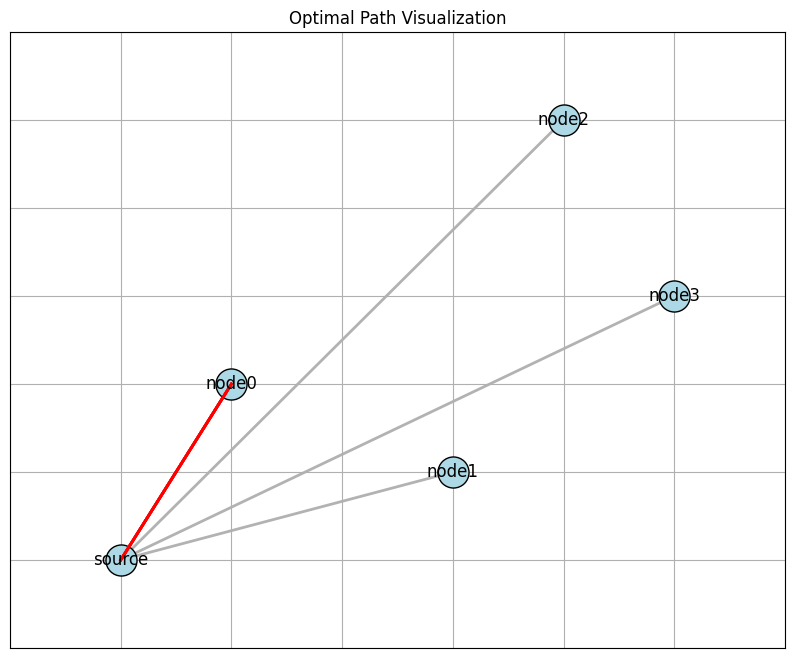

In [38]:
# Setup and run PyGAD
source = (0, 0)
nodes = [(1, 2), (3, 1), (4, 5), (5, 3)]
G = graph_single_source(source, nodes)

ga_instance = pygad.GA(
    num_generations=1000,
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=len(nodes),
    gene_type=int,
    init_range_low=0,
    init_range_high=len(nodes) - 1,
    mutation_type="random",
    mutation_percent_genes=5,
)

# Run GA
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print(f"Optimal order: {solution}")
print(f"Fitness value: {solution_fitness}")

# Plot the graph with the optimal order
plot_graph(G, solution)